In [1]:
!pip install -q transformers torchaudio librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 811.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.3 MB/s eta 0:00:00


In [2]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/MyDrive/cv-corpus-22.0-delta-2025-06-20-en.tar.gz'

In [7]:
import tarfile
with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall(path='/content/')
    print("تم فك الضغط في /content/")

✅ تم فك الضغط في /content/


In [8]:
import pandas as pd
import shutil
import os

# تحديد المسارات
base_path = "/content/cv-corpus-22.0-delta-2025-06-20/en"
tsv_path = os.path.join(base_path, "validated.tsv")
clips_path = os.path.join(base_path, "clips")
output_dir = "/content/my_20_samples"

# إنشاء مجلد لحفظ العينات
os.makedirs(output_dir, exist_ok=True)

# قراءة ملف الجمل الصوتية
df = pd.read_csv(tsv_path, sep='\t')

# التأكد من الأعمدة المطلوبة
if 'path' in df.columns and 'sentence' in df.columns:
    samples = df[['path', 'sentence']].head(20)

    # نسخ أول 20 ملف صوتي
    for _, row in samples.iterrows():
        src = os.path.join(clips_path, row['path'])
        dst = os.path.join(output_dir, row['path'])
        shutil.copyfile(src, dst)

    # حفظ الجمل في ملف metadata
    samples.to_csv(os.path.join(output_dir, 'metadata.csv'), index=False)

    print("تم استخراج أول 20 ملف صوتي إلى:", output_dir)
else:
    print("ملف validated.tsv لا يحتوي على الأعمدة المطلوبة: 'path' و 'sentence'")


✅ تم استخراج أول 20 ملف صوتي إلى: /content/my_20_samples


In [11]:
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
import librosa
import os

# تحميل الموديل والتوكنيزر
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

audio_folder = "/content/drive/MyDrive/my_20_samples_backup"
output = []

for file in os.listdir(audio_folder):
    if file.endswith(".mp3"):
        path = os.path.join(audio_folder, file)

        speech, sr = librosa.load(path, sr=16000)
        input_values = tokenizer(speech, return_tensors="pt", padding="longest").input_values

        # التنبؤ بالنص
        with torch.no_grad():
            logits = model(input_values).logits

        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = tokenizer.batch_decode(predicted_ids)[0].lower()

        output.append({
            "file": file,
            "wav2vec_transcription": transcription
        })

# حفظ النتائج
import pandas as pd
df_wav2vec = pd.DataFrame(output)
df_wav2vec.to_csv("/content/my_20_samples/wav2vec_transcripts.csv", index=False)
print("✅ تم استخراج النصوص باستخدام Wav2Vec 2.0 بنجاح.")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:720: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ تم استخراج النصوص باستخدام Wav2Vec 2.0 بنجاح.


In [13]:
!pip install jiwer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.8 MB/s eta 0:00:00


                           file       wer
0  common_voice_en_43193287.mp3  0.416667
1  common_voice_en_43139615.mp3  0.250000
2  common_voice_en_42751082.mp3  0.444444
3  common_voice_en_43204215.mp3  0.357143
4  common_voice_en_42791629.mp3  1.000000


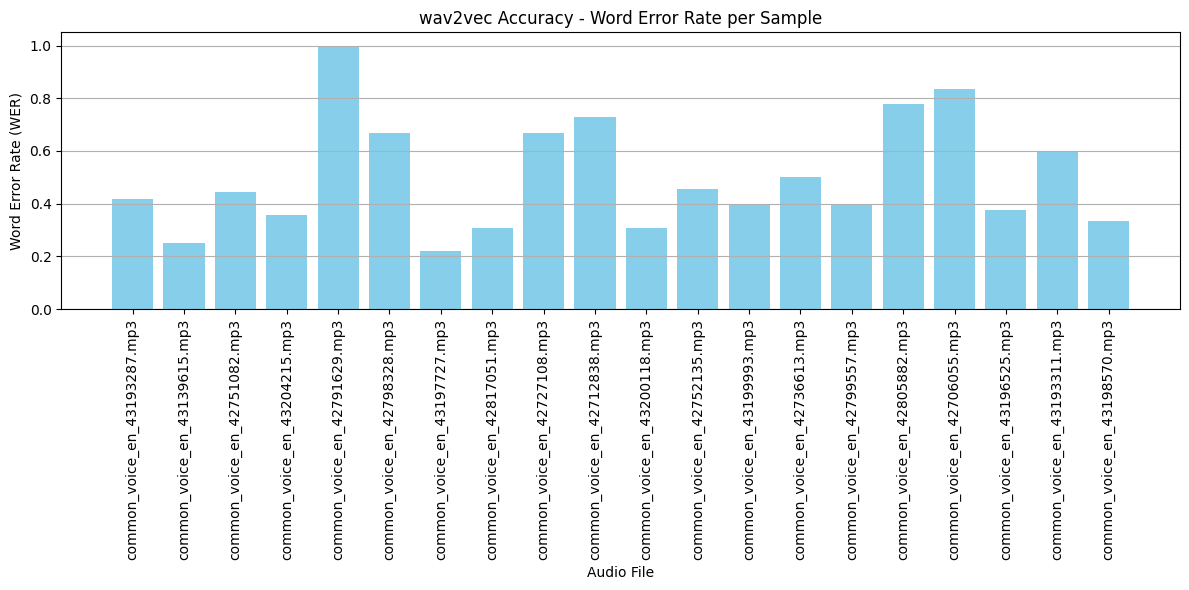

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from jiwer import wer

# تحميل نتائج wav2vec
df_wav2vec = pd.read_csv('/content/my_20_samples/wav2vec_transcripts.csv')

# تحميل الجمل الأصلية
df_original = pd.read_csv('/content/my_20_samples/metadata.csv')

# دمج البيانات بناءً على اسم الملف
df_merged = pd.merge(df_wav2vec, df_original, left_on='file', right_on='path')

# حساب WER لكل سطر
df_merged['wer'] = df_merged.apply(lambda row: wer(row['sentence'], row['wav2vec_transcription']), axis=1)

# عرض أول 5 نتائج كمثال
print(df_merged[['file', 'wer']].head())

# رسم WER لكل ملف
plt.figure(figsize=(12, 6))
plt.bar(df_merged['file'], df_merged['wer'], color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("Word Error Rate (WER)")
plt.xlabel("Audio File")
plt.title("wav2vec Accuracy - Word Error Rate per Sample")
plt.grid(axis='y')
plt.tight_layout()
plt.show()